## 1. Random Distributions for Simulations

Random distributions are fundamental to discrete-event simulations. They allow us to model unpredictable real-world phenomena like customer arrival times, service durations, and system failures. This section explores three commonly used distributions in simulation: **uniform**, **normal**, and **exponential**. Each has distinct characteristics that make them suitable for different types of events.

### 1.1 Generating and Visualising Distributions

The following code snippet demonstrates how to generate 1000 random numbers from the uniform distribution and visualise them in a histogram.


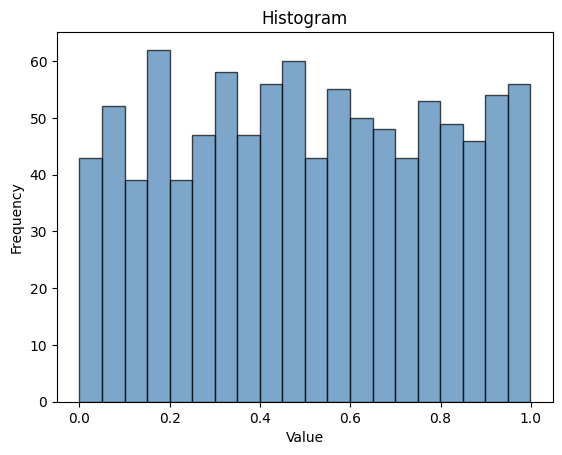

In [62]:
import numpy as np
import matplotlib.pyplot as plt

data = np.random.uniform(0, 1, 1000)
plt.hist(data, bins=20, edgecolor='black', alpha=0.7, 
         color='steelblue')
plt.xlabel('Value')
plt.ylabel('Frequency') 
plt.title('Histogram')
plt.show()



#### Try It Yourself

1. Try to generate and visualise the data generated from uniform, normal and exponential distributions. Use the following parameters: a=1.0, b=5.0 for uniform, mu=5.0 and std=2.0 for the normal and lambda=2.0 for the exponential distribution.

1. Calculate and display the mean, standard deviation, minimum, and maximum for data generated from each distribution. Compare them to the original parameters. 

1. Compare the summary and visualisation results for distributions generated with 1000 and 100 numbers respectively. 

1. Which distribution has the highest variability? Which is most symmetric?

### 1.2 Exponential Distribution for Arrival Times

The exponential distribution is commonly used in simulation to model inter-arrival times (time between consecutive customer arrivals) and service times. In SimPy simulations, we use `random.expovariate(λ)` where λ (lambda) is the **arrival rate**. For example, λ=1.0 means an average of 1 customer per time unit, so the average inter-arrival time is 1/λ = 1 time unit.

#### Try It Yourself

1. Generate 10,000 inter-arrival times using the exponential distribution with three different rates: λ = 0.5, 1.0, and 2.0. Create histograms for each rate and summary statistics as in the previous task to see how increasing λ affects the distribution.


## 2. Monte-Carlo Simulation

### 2.1 Implementation

This section demonstrates a Monte-Carlo approach where multiple simulation runs are executed to obtain more reliable statistical estimates. Each simulation run uses the same queue model structure, building on the distributions introduced in Section 1. We collect the average statistics of each metric at the end of each run. The results present sample mean and standard error values at 95% confidence intervals.

**Key concepts:**
- Multiple independent simulation runs provide better statistical estimates
- Standard error measures the reliability of the sample mean
- Confidence intervals quantify the uncertainty in our results
- Exponential distributions model inter-arrival and service times

#### Try It Yourself

Run the simulation and inspect the results, paying attention to:
1. The number of runs completed
2. Expected values for each metric
3. Result variability (standard error and confidence intervals)

Try adjusting different simulation parameters and observe how they affect the results.

In [63]:
#import key libraries
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

def weighted_average(time_value_pairs):
    """Calculate weighted average from time-value pairs."""
    times, values = zip(*time_value_pairs)  # Unzip times and values into separate lists
    durations = np.diff(np.array(times, dtype=float))  # Convert to float and get differences/durations
    durations /= np.sum(durations)  # Normalise to get time proportions
    weighted_avg = np.sum(values[:-1] * durations)  # Weighted average
    return weighted_avg

def calculate_standard_error(data):
    """Calculate standard error from a list of values."""
    if len(data) < 2:
        return float('inf')
    variance = np.var(data, ddof=1)
    return np.sqrt(variance / len(data))

def print_summary_run(stats, run_number):
    """Print a summary of a single simulation run."""
    q_time, q_value = zip(*stats['queue_length'])  # Unzip times and values into separate lists

    summary_text = f"""
    SINGLE RUN SUMMARY (Run {run_number})
    ─────────────────────────
    Number of Servers: {SERVER_CAPACITY}
    Arrival Rate (λ): {ARRIVAL_RATE} customers/time unit
    Service Rate (μ): {SERVICE_RATE} customers/time unit/server
    Simulation Time: {env.now} time units

    RESULTS
    ─────────────────────────
    Total Customers Served: {len(stats['wait_time'])}

    WAIT TIME
    Average: {np.average(stats['wait_time']):.2f} time units
    Maximum: {np.max(stats['wait_time']):.2f} time units

    QUEUE LENGTH
    Average: {weighted_average(stats['queue_length']):.2f} customers
    Maximum: {np.max(q_value):.0f} customers

    SERVER METRICS
    Average Utilisation: {weighted_average(stats['utilisation']) * 100:.1f}%
    """
    print(summary_text)

def print_summary_sim(stats, actual_runs):
    """Print a summary of all simulation runs with statistical analysis."""

    summary_text = f"""
    MONTE-CARLO SIMULATION SUMMARY
    ═════════════════════════════════════════════════════════
    
    SIMULATION PARAMETERS
    ─────────────────────────
    Number of Servers: {SERVER_CAPACITY}
    Arrival Rate (λ): {ARRIVAL_RATE} customers/time unit
    Service Rate (μ): {SERVICE_RATE} customers/time unit/server
    Simulation Time per Run: {SIMULATION_TIME} time units
    Total Simulation Runs: {actual_runs}
    Standard Error Threshold (Relative): {SE_REL_THRESHOLD * 100:.1f}%
    Confidence Level: 95% (z-score = {CONFIDENCE_FACTOR})

    RESULTS FROM ALL SIMULATION RUNS
    ─────────────────────────
    Wait time: {np.average(stats['wait_time']):.3f} ± {CONFIDENCE_FACTOR * calculate_standard_error(stats['wait_time']):.3f} time units
    Queue length: {np.average(stats['queue_length']):.3f} ± {CONFIDENCE_FACTOR * calculate_standard_error(stats['queue_length']):.3f}
    Utilisation: {np.average(stats['utilisation']):.3f} ± {CONFIDENCE_FACTOR * calculate_standard_error(stats['utilisation']):.3f}
    """
    print(summary_text)

def get_simulation_stats(stats):
    """Calculate and return key statistics from a single simulation run."""
    return {
        'wait_time': np.average(stats['wait_time']),
        'queue_length': weighted_average(stats['queue_length']),
        'utilisation': weighted_average(stats['utilisation'])
    }

def customer(env, name, server, service_time, stats):
    """
    Represents a customer arriving, waiting, being served, and leaving.
    
    Args:
        env: SimPy environment
        name: Customer identifier
        server: Resource instance
        service_time: Time required for service
        stats: Dictionary containing lists for different metrics
    """
    arrival_time = env.now
    
    # Log queue length and server utilisation at arrival
    stats['queue_length'].append((env.now, len(server.queue))) 
    stats['utilisation'].append((env.now, server.count / server.capacity))
    
    with server.request() as request:
        # Wait in queue (server.request() automatically logs utilisation)
        yield request
        wait_time = env.now - arrival_time
        stats['wait_time'].append(wait_time)
        
        # Being served
        yield env.timeout(service_time)

        # Log queue length and server utilisation after finishing
        stats['queue_length'].append((env.now, len(server.queue))) 
        stats['utilisation'].append((env.now, server.count / server.capacity))

def customer_generator(env, server, arrival_rate, service_rate, stats):
    """
    Generates customers arriving at the queue.
    
    Args:
        env: SimPy environment
        server: Resource instance
        arrival_rate: Average arrivals per time unit (lambda)
        service_rate: Average services per time unit (mu)
        stats: Dictionary to store statistics
    """
    customer_count = 0
    while True:
        # Wait for next arrival (exponentially distributed inter-arrival time)
        yield env.timeout(random.expovariate(arrival_rate))
        
        # Create new customer with exponentially distributed service time
        customer_count += 1
        service_time = random.expovariate(service_rate)
        env.process(
            customer(env, f'Customer {customer_count}', server, 
                    service_time, stats)
        )

# ═════════════════════════════════════════════════════════
# SIMULATION CONFIGURATION
# ═════════════════════════════════════════════════════════

ARRIVAL_RATE = 1.0             # Average 1 customer per time unit (lambda)
SERVICE_RATE = 2.0             # Average 2 customers served per time unit (mu)
SIMULATION_TIME = 480.0        # Run for 480 time units (e.g., 8 hours if 1 unit = 1 min)
SERVER_CAPACITY = 1            # Number of servers
SIM_RUNS = 50                  # Maximum number of simulation runs
SE_REL_THRESHOLD = 0.05        # Relative standard error threshold (5% for convergence)
CONFIDENCE_FACTOR = 1.96       # Z-score for 95% confidence intervals
USE_STOPPING_CRITERIA = False  # Enable early stopping when SE threshold is met
# random.seed(42)              # Uncomment for reproducibility

# ═════════════════════════════════════════════════════════
# RUN MONTE-CARLO SIMULATION
# ═════════════════════════════════════════════════════════

sim_stats = {
    'wait_time': [],
    'queue_length': [],
    'utilisation': []
}

for run in range(SIM_RUNS):
    # Create environment and initialise statistics dictionary
    env = simpy.Environment()
    stats = {
        'wait_time': [],
        'queue_length': [],
        'utilisation': []
    }

    # Create server resource
    server = simpy.Resource(env, capacity=SERVER_CAPACITY)

    # Start the customer generator process
    env.process(
        customer_generator(env, server, ARRIVAL_RATE, SERVICE_RATE, stats)
    )

    # Run simulation until SIMULATION_TIME
    env.run(until=SIMULATION_TIME)

    # Collect and store average statistics from this run
    run_stats = get_simulation_stats(stats)
    for key in sim_stats:
        sim_stats[key].append(run_stats[key])

    # Check convergence criterion based on relative standard error
    if USE_STOPPING_CRITERIA and run + 1 >= 5:
        sample_mean = np.average(sim_stats['wait_time'])
        sample_se = calculate_standard_error(sim_stats['wait_time'])
        
        # Calculate relative standard error (as percentage of mean)
        relative_error = CONFIDENCE_FACTOR * sample_se / sample_mean
        
        # Stop if relative error falls below threshold
        if relative_error < SE_REL_THRESHOLD:
            print(f"Convergence criterion met at run {run + 1}")
            print(f"Relative standard error: {relative_error * 100:.2f}% < {SE_REL_THRESHOLD * 100:.1f}%")
            SIM_RUNS = run + 1  # Update actual number of runs
            break

# Print final summary statistics
print_summary_sim(sim_stats, SIM_RUNS)



    MONTE-CARLO SIMULATION SUMMARY
    ═════════════════════════════════════════════════════════
    
    SIMULATION PARAMETERS
    ─────────────────────────
    Number of Servers: 1
    Arrival Rate (λ): 1.0 customers/time unit
    Service Rate (μ): 2.0 customers/time unit/server
    Simulation Time per Run: 480.0 time units
    Total Simulation Runs: 50
    Standard Error Threshold (Relative): 5.0%
    Confidence Level: 95% (z-score = 1.96)

    RESULTS FROM ALL SIMULATION RUNS
    ─────────────────────────
    Wait time: 0.485 ± 0.039 time units
    Queue length: 0.488 ± 0.040
    Utilisation: 0.830 ± 0.004
    


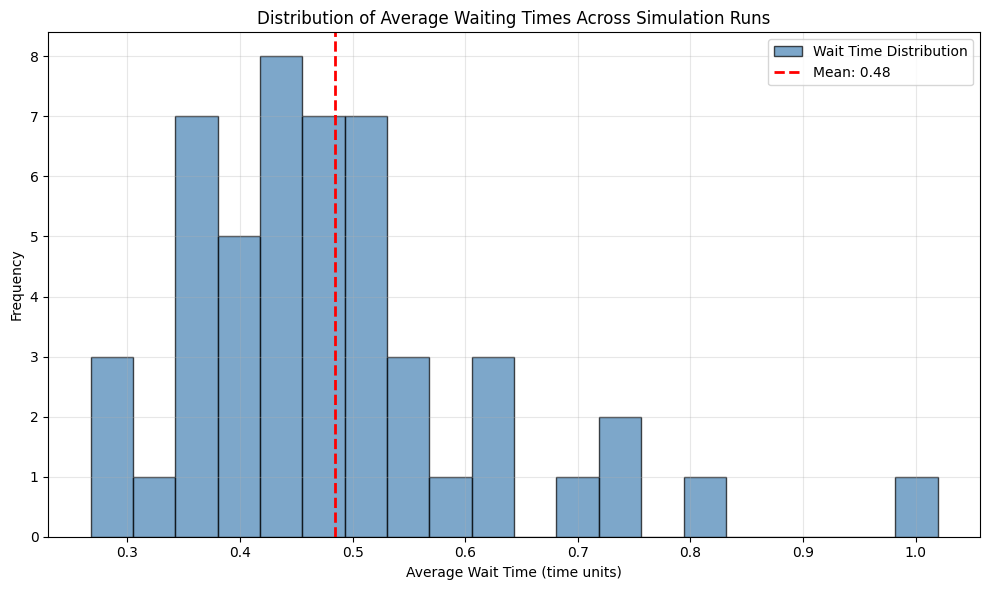

In [64]:
plt.figure(figsize=(10, 6))
plt.hist(sim_stats['wait_time'], bins=20, edgecolor='black', alpha=0.7, 
         color='steelblue', label='Wait Time Distribution')
plt.axvline(x=np.average(sim_stats['wait_time']), color='r', linestyle='--', 
            linewidth=2, label=f"Mean: {np.average(sim_stats['wait_time']):.2f}")
plt.xlabel('Average Wait Time (time units)')
plt.ylabel('Frequency') 
plt.title('Distribution of Average Waiting Times Across Simulation Runs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Result Analysis

#### Try It Yourself

1. Run the simulation for 50, 500, and 5000 runs. Visualise the results using histograms to understand the result distribution. Compare the sample mean and standard error values of wait times for each case, calculating also the final relative error (`1.96 * SE / sample_mean`). You can use the histogram code snipet from Task 1.

2. Repeat the same analysis for queue length and utilisation metrics. Which metric achieves the lowest relative error after 50, 500, and 5000 runs? Why might this be the case?

3. A single simulation run was performed for 480 time units (equivalent to a working day of 8 hours if 1 time unit = 1 minute). Compare the standard error values for wait time between simulation runs with different durations:
   - One working day: 480 time units
   - One hour: 60 time units
   
   Which case leads to lower standard errors and why?


### 2.4 Early Stopping Criteria

The simulation features an early stopping criterion which halts the simulation when a specified level of statistical precision has been reached, rather than running a fixed number of iterations. The `USE_STOPPING_CRITERIA` parameter enables this feature. The stopping criterion is based on the relative standard error (95% confidence): it stops when `1.96 * SE / mean < SE_REL_THRESHOLD`.

**Key principle**: The simulation stops early when results become sufficiently stable, reducing unnecessary computation whilst maintaining statistical reliability.

#### Try It Yourself

1. Set `SIM_RUNS = 10000` and enable the early stopping criterion by setting `USE_STOPPING_CRITERIA = True`. Run the simulation and find how many runs were actually required to reach the default 5% relative error for each of the three metrics (wait time, queue length, utilisation).

2. Repeat the task with a more stringent criterion (`SE_REL_THRESHOLD = 0.025` for 2.5% relative error). How many additional simulation runs were required to reach this lower error threshold for each metric?

3. Compare the number of runs required to achieve 5% relative error between:
   - One working day simulation (480 time units)
   - One hour simulation (60 time units)
   
   Using the wait time metric, discuss why the required number of runs differs between these scenarios.


## 3. Agent-based Simulation

This section introduces agent-based simulation, a different paradigm from the process-based approach used in Sections 2.1–2.4. Rather than individual customers or processes, agent-based models consist of multiple autonomous entities (agents) that interact with each other and their environment to produce emergent behaviours.

We will explore agent-based simulation using NetLogo, a web-based platform designed for this purpose. The example below demonstrates predator-prey dynamics.

**Learning objectives:**
- Understand the difference between process-based and agent-based simulation approaches
- Familiarise yourself with NetLogo's interface and model structure
- Observe emergent behaviour arising from simple agent interactions

#### Try It Yourself

1. Open the [Wolf Sheep Predation model](https://www.netlogoweb.org/launch#https://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Wolf%20Sheep%20Predation.nlogox) in NetLogo Web.

2. Read the **Model Info** section to understand the simulated scenario, including:
   - What agents are present and their roles?
   - What rules govern their interactions?
   - What outputs are tracked?

3. Try the tasks listed under **Things to Notice** and **Things to Try**:
   - Run the simulation with default parameters and describe what you observe
   - Adjust agent parameters (grass regrowth rate, initial predator/prey numbers) and explain how these changes affect the system dynamics
   - Identify which parameters lead to stable equilibrium, oscillations, or extinction
